# **Exercise 3: Advanced Feature Extraction and Image Processing**

**0.1 Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**0.2 Importing Libraries**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

**0.3 Initializing Functions**

In [ ]:
#Harris corner detection function
def harris_corner_detector(gray_image, image):
    dst = cv2.cornerHarris(gray_image, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    image[dst > 0.01 * dst.max()] = [0, 0, 255]
    return image

#HOG feature extraction function
def hog_descriptor(gray_image):
  fd, hog_image = hog(gray_image,
                      orientations=8,
                      pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1),
                      visualize=True)

  return hog_image

#FAST keypoint detection function
def fast_keypoint_detector(gray_image, image):
  fast = cv2.FastFeatureDetector_create()
  kp = fast.detect(gray_image, None)
  fast_image = cv2.drawKeypoints(image, kp, None, color=(255, 0, 0))
  return fast_image


#Feature matching ORB and FLANN
def orb_flann_feature_matching(image1, image2):
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    keypoints_flann1, descriptors_flann1 = orb.detectAndCompute(image1, None)
    keypoints_flann2, descriptors_flann2 = orb.detectAndCompute(image2, None)

    # FLANN parameters for ORB (using LSH as it's more suitable for binary descriptors)
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,    # 12 is a good value
                        key_size=12,       # 20 is a good value
                        multi_probe_level=1)  # 2 is a good value
    search_params = dict(checks=50)  # or pass an empty dictionary

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Match descriptors using KNN
    f_matches = flann.knnMatch(descriptors_flann1, descriptors_flann2, k=2)

    # Apply Lowe's ratio test to filter out poor matches
    good_matches = []
    for match in f_matches:
        if len(match) == 2:
            m, n = match
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

    # Draw only the good matches
    flann_image = cv2.drawMatches(image1, keypoints_flann1, image2, keypoints_flann2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return flann_image

## **Exercise 1: Harris Corner Detection**

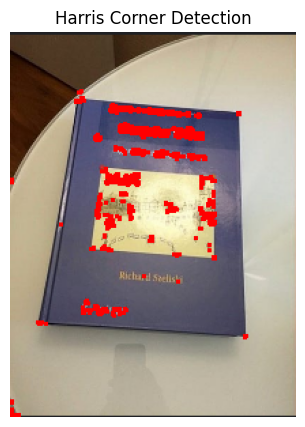

In [ ]:
#Load Image
image1_harris = cv2.imread('/content/drive/MyDrive/image11_2.png')

#Convert image to grayscale
gray_image1_harris = cv2.cvtColor(image1_harris, cv2.COLOR_BGR2GRAY)

#Apply harris detection
apply_harris = harris_corner_detector(gray_image1_harris, image1_harris)

#Plot the image
plt.figure(figsize=(7, 5))
plt.imshow(cv2.cvtColor(apply_harris, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Harris Corner Detection')
plt.show()

## **Exercise 2: HOG (Histogram of Oriented Gradients) Feature Extraction**

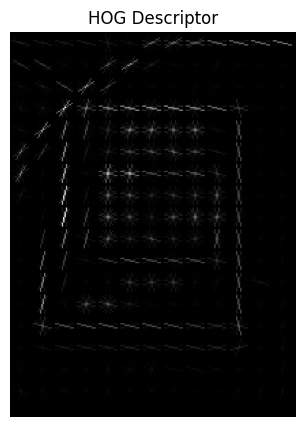

In [ ]:
#Load Image
image1_hog = cv2.imread('/content/drive/MyDrive/image11_2.png')

#Convert image to grayscale
gray_image1_hog = cv2.cvtColor(image1_hog, cv2.COLOR_BGR2GRAY)

#Apply HOG feature extraction
apply_hog = hog_descriptor(gray_image1_hog)

#Plot the image
plt.figure(figsize=(7, 5))
plt.imshow(apply_hog, cmap='gray')
plt.axis('off')
plt.title('HOG Descriptor')
plt.show()

## **Exercise 3: FAST(Features from Accelerated Segment Text) Keypoint Detection**

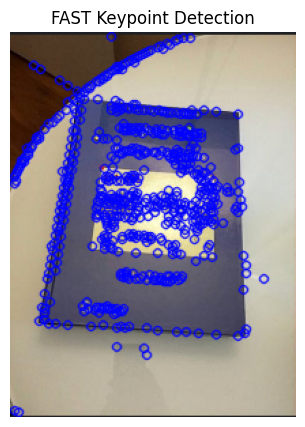

In [ ]:
#Load Image
image1_fast = cv2.imread('/content/drive/MyDrive/image11_2.png')

#Convert image to grayscale
gray_image1_fast = cv2.cvtColor(image1_fast, cv2.COLOR_BGR2GRAY)

#Applt FAST keypoint detector
apply_fast = fast_keypoint_detector(gray_image1_fast, image1_fast)

#Plot the image
plt.figure(figsize=(7, 5))
plt.imshow(cv2.cvtColor(apply_fast, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('FAST Keypoint Detection')
plt.show()

## **Exercise 4: Feature Matching using ORB and FLANN**

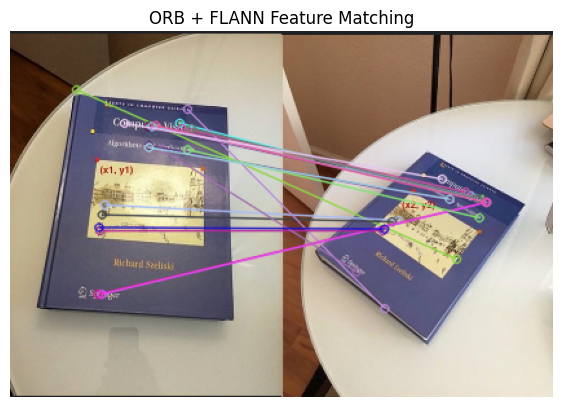

In [ ]:
#Load Images
image1_orb_flann = cv2.imread('/content/drive/MyDrive/image11_2.png')
image2_orb_flann = cv2.imread('/content/drive/MyDrive/image11_3.png')

#Convert images to grayscale
gray_image1_orb_flann = cv2.cvtColor(image1_orb_flann, cv2.COLOR_BGR2RGB)
gray_image2_orb_flann = cv2.cvtColor(image2_orb_flann, cv2.COLOR_BGR2RGB)

#Apply ORB and FLANN feature matching
orb_flan = orb_flann_feature_matching(gray_image1_orb_flann, gray_image2_orb_flann)

#Plot the image
plt.figure(figsize=(7, 5))
plt.imshow(orb_flan)
plt.axis('off')
plt.title('ORB + FLANN Feature Matching')
plt.show()


## **Exercise 5: Image Segmentation using Watershed Algorithm**

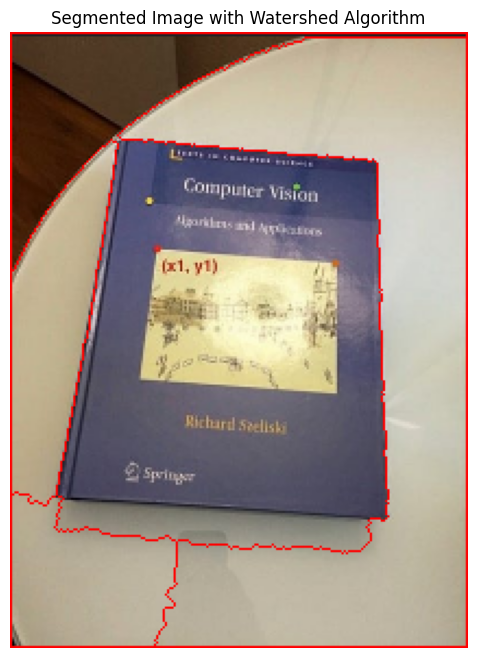

In [ ]:
#Load Image
image1_watershed = cv2.imread('/content/drive/MyDrive/image11_2.png')

#Convert image to grayscale
gray_image1_watershed = cv2.cvtColor(image1_watershed, cv2.COLOR_BGR2GRAY)

#Apply thresholding (e.g., binary thresholding)
ret, thresholded_image = cv2.threshold(gray_image1_watershed, 127, 255, cv2.THRESH_BINARY)

#Noise removal using morphological opening (erosion followed by dilation)
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresholded_image, cv2.MORPH_OPEN, kernel, iterations=2)

#Sure background area (dilation)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

#Sure foreground area (distance transform and thresholding)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

#Unknown region (subtract sure_fg from sure_bg)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

#Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)

#Add one to all markers so that sure background is not 0, but 1
markers = markers + 1

#Mark the unknown regions with zero
markers[unknown == 255] = 0

#Apply Watershed algorithm
markers = cv2.watershed(image1_watershed, markers)

#Marking boundaries (-1 indicates the boundary in markers)
image1_watershed[markers == -1] = [0, 0, 255]  # Mark boundaries in red

#Plot the image
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image1_watershed, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
plt.axis('off')
plt.title('Segmented Image with Watershed Algorithm')
plt.show()
